# Imports and definitions

In [170]:
from __future__ import division
from __future__ import print_function

%matplotlib inline
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
sns.set_color_codes()
import numpy as np
import pandas
import timeit #more accurate than time

# import theano
import tensorflow

from sklearn.decomposition import PCA
# from sklearn.externals import joblib
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.models import Sequential, model_from_json, load_model, clone_model
# from keras.optimizers import SGD
# from keras.optimizers import Nadam
from tensorflow.keras.optimizers import Adam


from sklearn.utils import shuffle

from six.moves import cPickle #Faster than pickle

import ipykernel

## Neural Nets functions

In [67]:
def getDistribuitionFitter(model, compileArgs):
    classModel = Sequential()
    depth = None
    width = None
    step = None
    fit_func = 'sigmoid' 
    layerSizes = []

    if model == "model1":   # for an approximately linear fit
        layerSizes = [20, 4, 5]
    elif model == "model0":
        layerSizes = [10, 5]        
    
    for i,width in enumerate(layerSizes):
        if i==0:
            classModel.add(Dense(width, input_shape=(1,), kernel_initializer='normal', activation=fit_func))
        else:
            classModel.add(Dense(width, kernel_initializer='normal', activation=fit_func))
    
    classModel.add(Dense(1, kernel_initializer='normal'))

    classModel.compile(**compileArgs)

    return classModel
  

## Callbacks

In [3]:
class LossHistory(Callback):
    def __init__(self, trData):
        self.trainingData = trData
    def on_train_begin(self, logs={}):
        self.losses = {}
        self.losses['loss'] = []
        self.losses['val_loss'] = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses['loss'].append(self.model.evaluate(self.trainingData[0], self.trainingData[1], verbose=0))
        self.losses['val_loss'].append(logs.get('val_loss'))
        

In [4]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True
    

## Distribution Fit Definition

In [5]:

class DistribuitionFit:

    # default parameters
    compileArgs = {'loss':'mean_squared_error', 
              'optimizer':'Adam'}
    
    trainParams     = {'epochs' : 3000, 
                   'batch_size' : 30, 
                      'verbose' : 2}

    netModel = None
    norm_const = 1
    x_train = None
    y_train = None
    xrange = (-1, 1)
    has_train = False
    h = 1.0e-3 # this value can change with Ntot and dataRange
    def __init__(self, compileArgs={}, trainParams={}, modelID='model1', weights=None, baseModel=None):
        for args in compileArgs:
            self.compileArgs[args] = compileArgs[args] 

        for params in trainParams:
            self.trainParams[params] = trainParams[params]

        if not baseModel:
            self.netModel = getDistribuitionFitter(modelID, self.compileArgs)
        else:
            self.netModel = clone_model(baseModel)
        
        if weights:
            self.netModel.set_weights(weights)
        
        # self.netModel.summary()

    def count(sortedData, x):
        for i in range(len(sortedData)):
            if x < sortedData[i]:
                return (i+0.)/(len(sortedData))
        return 1

    def train(self, data, xrange=None, h=None, trainParams=None ,verbose=0, 
              xrange_excess=0, density=50, edge_density_mult=1, do_train=True): 
        # data:  raw, unsorted random data from some distribuition
        # xrange: range to fit
        # xrange_excess: extra range from the borders in percentage of total range
        # edge_fix: how much does the density increases at the excess zone
        data.sort()
        self.data = np.array(data)

        if not xrange:
            xrange = (data[0], data[-1])

        self.xrange0 = xrange

        xdelta_excess = (xrange[1]-xrange[0])*xrange_excess/2
        xdelta = (xrange[1]-xrange[0])/2 + xdelta_excess
        xcenter = (xrange[1]+xrange[0])/2
        self.xrange = (xcenter-xdelta, xcenter+xdelta)
       
        # the lower this value the more oscillations there are on the derivative
        if h == None:
            self.h = (self.xrange[1]-self.xrange[0])*1.0e-5
        else:
            self.h = h

        if not trainParams:
            trainParams = self.trainParams

        if do_train: # in case one only wants to initialise the data 
            N = len(data)

            arr = np.array([])
            # arr = np.append(arr, self.xrange[0]-xdelta_excess, self.xrange[0], 
            #                       edge_density_mult*xrange_excess*N))
            arr = np.append(arr, np.linspace(xrange[0]-xdelta_excess, xrange[0],
                                            int(N*density*edge_density_mult*xrange_excess)))
            arr = np.append(arr, np.linspace(*xrange, int(N*density)))
            arr = np.append(arr, np.linspace(xrange[1], xrange[1]+xdelta_excess, 
                                            int(N*density*edge_density_mult*xrange_excess)))

            self.x_train = np.unique(arr)

            self.y_train = np.array([DistribuitionFit.count(data, x) for x in self.x_train])

            lossHistory = LossHistory( (self.x_train, self.y_train))
            earlyStop = EarlyStopping(monitor="loss", patience=3, verbose=0, mode="auto")

            # print(len(self.x_train), len(self.y_train))
        
            c = self.netModel.fit(self.x_train, self.y_train, **trainParams, callbacks=[lossHistory, earlyStop])
            self.has_train=True
            if verbose==2:
                self.plotIntegratedComparison()

            return c 

    def normalise(self, dx=0, h=0):
        if dx==0: dx = self.h*10
        # print(*self.xrange, (self.xrange[1]-self.xrange[0])/dx)
        
        xval = np.linspace(*self.xrange, int((self.xrange[1]-self.xrange[0])/dx))
 
        self.norm_const = np.sum(self.probability_array(xval, h))*dx 

    def probability(self, x, h=0):
        if h==0: h = self.h 
        if x <= self.xrange0[0] or x >= self.xrange0[1]: # if its outside of range
            return 0
        p1, p0 = self.netModel.predict((x+h, x-h))
        val = (p1[0]-p0[0])/(2*h*self.norm_const)
        if val>0:
            return val
        else:
            return 0

    def probability_array(self, xarray, h=0):
        if h==0: h = self.h 

        arr_plus = np.array([v[0] for v in self.netModel.predict([x+h for x in xarray ])])
        arr_minus= np.array([v[0] for v in self.netModel.predict([x-h for x in xarray ])])

        temp = []
        for i,x in enumerate(xarray):
            if x <= self.xrange0[0] or x >= self.xrange0[1]:# if its outside of range
                temp.append(0)
            else:
                val = (arr_plus[i]-arr_minus[i])/(2*h*self.norm_const)
                if val<0:
                    temp.append(0)
                else:
                    temp.append(val)

        return np.array(temp)

    def plotIntegratedComparison(self):
        # plots the integrated histogram and its fit (direct output from fit)

        # plt.plot(x_train_data, y_train_data)
        if not self.has_train or not self.netModel:
            print(" Model hasn't yet trained! No data!")
            return
        xval = np.linspace(*self.xrange, 400)
        y_test = self.netModel.predict(xval)

        plt.plot(xval, y_test)
        plt.plot(self.x_train, self.y_train)

    def plotHist(self, xrange=(), histparams={}):
        # plots the data histogram
        if not xrange:
            xrange = self.xrange
        ax = sns.distplot(self.data, norm_hist = True, kde=False, **histparams)
        # plt.hist(self.csv_file[self.features[k]] , **params)
        if range:
            ax.set_xlim(*xrange)
        else:
            ax.set_xlim(*xrange)
        # plt.legend()
    
    def plotDistribuition(self, xrange=(), histparams={}, nPoints=200):
        # plots the probability values
        if not xrange:
            xrange = self.xrange
        xval = np.linspace(*xrange, nPoints)
        plt.plot(xval, self.probability_array(xval))
        
        

## MultiFeature fit class

In [6]:
# default ranges: (-1, 1) for all except: Impact Parameter -> (-1, 10)


class MultiFeature :
    
    # default parameters = {}
    compileArgs = {'loss':'mean_squared_error', 
            'optimizer':'Adam'}
        
    trainParams = {'epochs' : 100,
                'batch_size' : 50, 
                    'verbose' : 2}

    trainParams_getfile = {'epochs' : 1,
                'batch_size' : 50, 
                    'verbose' : 0}

    fitParams_getfile = {'verbose':2, 
                    'xrange_excess': 0.2,
                    'density': 0,
                    'edge_density_mult':3}

    distfit_array = None
    features = []
    csv_file = None
    dev_data = None
    val_data = None

    def __init__(self, csv_file, features, parameters={}, xrange=None):
        # features: list of strings
        self.csv_file = csv_file
        self.features = features 
        trainParams = {}
        compileArgs = {}

        self.dev_data = {}
        self.val_data = {}
        self.distfit_array = {}

        if 'trainParams' in parameters:
            for pars in parameters['trainParams']:
                if pars in parameters['trainParams']:
                    self.trainParams[pars] = parameters['trainParams'][pars]
        
        if 'compileArgs' in parameters:
            for args in parameters['compileArgs']:
                if args in parameters['compileArgs']:
                    self.compileArgs[args] = parameters['compileArgs'][args]
        
        

        # self.distfit = DistribuitionFit(trainParams=self.trainParams, compileArgs=self.compileArgs)
        for k, feat in enumerate(features):
            param_model = "model_{}".format(k)
            if param_model in parameters:
                self.distfit_array[feat] = DistribuitionFit(trainParams=self.trainParams, 
                                                            compileArgs=self.compileArgs, modelID=parameters[param_model])
            else:
                self.distfit_array[feat] = DistribuitionFit(trainParams=self.trainParams, 
                                                            compileArgs=self.compileArgs)
            # a,b = train_test_split(self.csv_file[feat], test_size=split)
            self.dev_data[feat] = self.csv_file[feat]
            # self.val_data[feat] = b
            # print(feat, len(self.dev_data[feat]), len(self.val_data[feat]))
        
        if xrange:
            self.normalise_ranges(xrange)

    def fitFeature(self, k, fitParams={}, trainParams=None):
        feat = self.features[k]
        if not trainParams:
            trainParams = self.trainParams
        self.distfit_array[feat].train(self.dev_data[feat].to_numpy(), **fitParams, trainParams=trainParams)
        self.distfit_array[feat].normalise()
        
        print(k, ' Finished fitting ', feat)
        
    def resetFit(self,k, modelID=None):
        feat = self.features[k]
        if not modelID:
            self.distfit_array[feat] = DistribuitionFit(self.compileArgs, self.trainParams)
        else:
            self.distfit_array[feat] = DistribuitionFit(self.compileArgs, self.trainParams, modelID)

    def normalise_ranges(self, xrange=(-1, 1)):
        # normalise dev_data and val_data
        x_delta = xrange[1]-xrange[0]
        for feat in self.features:
            dev_max = np.max(self.dev_data[feat])
            dev_min = np.min(self.dev_data[feat])
            
            dev_delta = dev_max - dev_min
            
            self.dev_data[feat] = (self.dev_data[feat]-dev_min)*x_delta/dev_delta + xrange[0]
            # self.val_data[feat] = (self.val_data[feat]-dev_min)*x_delta/dev_delta + xrange[0]
    
    def normalise_range(self, k, xrange=(-1, 1)):
        # normalise dev_data and val_data
        feat = self.features[k]
        x_delta = xrange[1]-xrange[0]
        
        dev_max = np.max(self.dev_data[feat])
        dev_min = np.min(self.dev_data[feat])
        
        dev_delta = dev_max - dev_min
        
        self.dev_data[feat] = (self.dev_data[feat]-dev_min)*x_delta/dev_delta + xrange[0]
        # self.val_data[feat] = (self.val_data[feat]-dev_min)*x_delta/dev_delta + xrange[0]
    
    def save_distribuitions_to_file(self, dirname):
        if not os.path.isdir(dirname):
            os.makedirs(dirname)
        for feat in self.features:
            filename = "{}\\feature-{}.h5".format(dirname, feat.replace("/", "_"))
            self.distfit_array[feat].netModel.save(filename)
    
    def get_distribuitions_from_file(self, dirname, verbose=0):
        # make sure to set the ranges to the right values
        for k,feat in enumerate(self.features):
            if verbose==1:
                print("Loading model ", feat)
            filename = "{}\\feature-{}.h5".format(dirname, feat.replace("/", "_"))
            if not os.path.exists(filename):
                print("weight file ", filename, " doesn't exist")
            self.distfit_array[feat].netModel = load_model(filename, compile = False)
            self.fitFeature(k, {'do_train':False})
            self.distfit_array[feat].normalise()

    def drawFeatureHist(self, k, params={}, xrange=()):
        self.distfit_array[self.features[k]].plotHist(xrange, params)
        
    def fitAll(self, fitParams, trainParams=None):
        if trainParams:
            for k,feat in enumerate(self.features):
                self.fitFeature(k, fitParams, trainParams=trainParams)
                if 'verbose' in fitParams and fitParams['verbose']==2:
                    plt.show()
        else:
            for k,feat in enumerate(self.features):
                self.fitFeature(k, fitParams)
                if 'verbose' in fitParams and fitParams['verbose']==2:
                    plt.show()

    def drawDistComparison(self, k, params={}, xrange=()):
        # compares the distribuition (probability) to the histogram
        self.drawFeatureHist(k, params, xrange)
        self.distfit_array[self.features[k]].plotDistribuition(xrange, params)


In [256]:
def showDistribuition(dist, data, xprob_range, color='b', nPoints=200, histparams={}):
    # Signal Plot
    xrange_min = np.min(data)
    xrange_max = np.max(data)
    xrange_delta = xrange_max- xrange_min
    
#     print(xrange_min, xrange_max)
    
    xprob = np.linspace(*xprob_range,nPoints)
    xprob_delta = xprob_range[1]-xprob_range[0]
    
    yprob = dist.probability_array(xprob)
    xtrue = np.linspace(xrange_min, xrange_max, nPoints)
    
    plt.plot(xtrue, yprob*(xprob_delta)/(xrange_delta),color=color, linestyle='dashed')
    ax = sns.distplot(data, norm_hist = True, kde=False, color=color, **histparams)

# Select decay

In [260]:
# Decays ->  [1] ('pi pi', 'pi mu') [2] ('K mu', 'mu mu')

# susy = 1, 2
# decay = [susy=1] ('pi pi', 'pi mu') [susy=2] ('K mu', 'mu mu')
# Nmass = 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 'All'
decay_select = { 'susy':1, 
                'decay':'pi mu', 
                'Nmass':'All'}

## Loading signal and background files

In [261]:
all_signal_ID = {}

for Nmass in [0.6,0.8,1.0,1.2,1.4,1.6]:
    all_signal_ID[Nmass] = {}
    
    all_signal_ID[Nmass][1] = {}
    all_signal_ID[Nmass][1]['pi pi'] = ("pi- pi+ ",)
    all_signal_ID[Nmass][1]['pi mu'] = ("pi- mu+ ", "mu- pi+ ")

    all_signal_ID[Nmass][2] = {}
    all_signal_ID[Nmass][2]['K mu'] = ("K- mu+ ", "mu- K+ ")
    all_signal_ID[Nmass][2]['mu mu'] =("mu+ mu- ",)

signal_files = []
background_files = []

background_types = ['e', 'e_bar', 'mu', 'mu_bar']

if decay_select['Nmass'] == 'All':
    for nmass in [0.6, 0.8, 1.0, 1.2, 1.4, 1.6]:
        susy = decay_select['susy']
        decay_type = decay_select['decay']
        for dec in all_signal_ID[ nmass ][ susy ][ decay_type ]:
            signal_files.append("ShipAnalysis/NeutralinoDecayData/decay3/SfMass=1000/N0Mass={0}/susyBench{1}/kinematic_variables_{2}.dat".format(nmass, susy, dec))
            for backtype in background_types:
                background_files.append("SHiP-Data/Raul/{0}/kinematic_variables_{1}.dat".format(backtype, dec))
else:
    nmass = decay_select['Nmass']
    susy = decay_select['susy']
    decay_type = decay_select['decay']
    for dec in all_signal_ID[ nmass ][ susy ][ decay_type ]:
        signal_files.append("ShipAnalysis/NeutralinoDecayData/decay3/SfMass=1000/N0Mass={0}/susyBench{1}/kinematic_variables_{2}.dat".format(nmass, susy, dec))
        for backtype in background_types:
                background_files.append("SHiP-Data/Raul/{0}/kinematic_variables_{1}.dat".format(backtype, dec))

def read_csvs_and_concat(filename_list):
    file_list = []
    for filename in filename_list:
        file_list.append(pandas.read_csv(filename))
    
    return pandas.concat(file_list)

FullSignal_file = read_csvs_and_concat(signal_files)
FullBackground_file = read_csvs_and_concat(background_files)

print(len(FullSignal_file))
print(len(FullBackground_file))

# defaults
compileArgs = {'loss':'mean_squared_error', 
          'optimizer':'Adam'}
    
trainParams = {'epochs' : 150,
            'batch_size' : 10, 
                'verbose' : 2}

all_features = {}
for i,name in enumerate(FullSignal_file.columns):
    all_features[i] = name
print(all_features)

selected_features = [0,1,2,3,5,6,7,8,9,10,11,12,13,14]

feature_names = [all_features[i] for i in selected_features]

# print(len(mf_signal.dev_data[feature_names[0]]), len(mf_background.dev_data[feature_names[0]]))

290
8280
{0: 'Mother Total Momentum (GeV/c)', 1: ' Mother Transverse Momentum (GeV/c)', 2: ' Mother Fraction of Transverse Momentum', 3: ' Opening Angle (rad)', 4: ' Decay Angle (rad)', 5: ' Impact Parameter (cm)', 6: ' Daughter1 Total Momentum (GeV/c)', 7: ' Daughter1 Transverse Momentum (GeV/c)', 8: ' Daughter1 Fraction of Transverse Momentum', 9: ' Daughter2 Total Momentum (GeV/c)', 10: ' Daughter2 Transverse Momentum (GeV/c)', 11: ' Daughter2 Fraction of Transverse Momentum', 12: ' Decay Z (cm)', 13: ' Decay X (cm)', 14: ' Decay Y (cm)', 15: ' Event type'}


# Visualization

In [193]:
signal_data = {}
background_data = {}
for k, feat in enumerate(feature_names):
    signal_data[feat] = FullSignal_file[feat]
    background_data[feat] = FullBackground_file[feat]
    
dirname = "Network Saves/"
signal_file_to_view = "{}/signal-2-{}/".format(dirname, decay_select['decay'])

    
mf_signal = MultiFeature(FullSignal_file, feature_names, 
                         parameters={'trainParams': trainParams, 
                                     'compileArgs':compileArgs}, xrange=(-1,1))
mf_signal.normalise_range(4, (-1,10))
mf_signal.get_distribuitions_from_file(signal_file_to_view)


background_file_to_view = "{}/background-2-{}/".format(dirname, decay_select['decay'])

mf_background = MultiFeature(FullBackground_file, feature_names, 
                         parameters={'trainParams': trainParams, 
                                     'compileArgs':compileArgs}, xrange=(-1,1))
mf_background.normalise_range(4, (-1,10))
mf_background.get_distribuitions_from_file(background_file_to_view)
    
    

0  Finished fitting  Mother Total Momentum (GeV/c)
1  Finished fitting   Mother Transverse Momentum (GeV/c)
2  Finished fitting   Mother Fraction of Transverse Momentum
3  Finished fitting   Opening Angle (rad)
4  Finished fitting   Impact Parameter (cm)
5  Finished fitting   Daughter1 Total Momentum (GeV/c)
6  Finished fitting   Daughter1 Transverse Momentum (GeV/c)
7  Finished fitting   Daughter1 Fraction of Transverse Momentum
8  Finished fitting   Daughter2 Total Momentum (GeV/c)
9  Finished fitting   Daughter2 Transverse Momentum (GeV/c)
10  Finished fitting   Daughter2 Fraction of Transverse Momentum
11  Finished fitting   Decay Z (cm)
12  Finished fitting   Decay X (cm)
13  Finished fitting   Decay Y (cm)
0  Finished fitting  Mother Total Momentum (GeV/c)
1  Finished fitting   Mother Transverse Momentum (GeV/c)
2  Finished fitting   Mother Fraction of Transverse Momentum
3  Finished fitting   Opening Angle (rad)
4  Finished fitting   Impact Parameter (cm)
5  Finished fitting   D

8  Daughter2 Total Momentum (GeV/c)


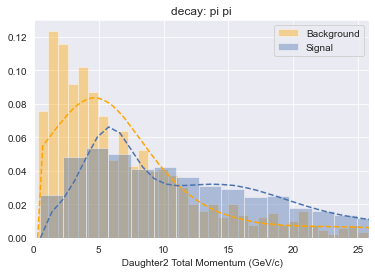

9  Daughter2 Transverse Momentum (GeV/c)


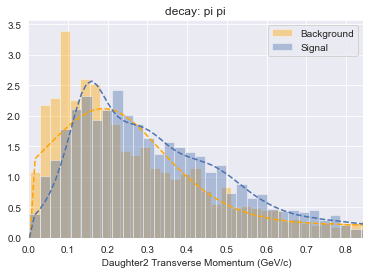

10  Daughter2 Fraction of Transverse Momentum


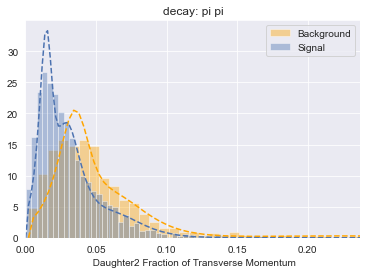

In [257]:
draw_features = range(len(feature_names))

draw_features = [8,9,10]

histparams = {'bins':100}
signal_params = {'bins':100, 'label':"Signal"}
background_params = {'bins':100, 'label':"Background"}
# xrange_min = 0
# xrange_max = 1.16
xrange_delta = 2

# def showDistribuition(dist, data, xprob_range, nPoints=200)

nPoints = 400
for k in draw_features:
    feat = feature_names[k]
    print(k, feat)
#     print(np.min(signal_data[feat]), np.max(signal_data[feat]))
    xmax = np.max(background_data[feat])
    xmin = np.min(background_data[feat])
    
    if k == 4:
        xprob_range = (-1, 10)
    else:
        xprob_range = (-1, 1)
        0
    showDistribuition(mf_background.distfit_array[feat], background_data[feat], xprob_range, color="orange", histparams=background_params)
    # Background Plot

    showDistribuition(mf_signal.distfit_array[feat], signal_data[feat], xprob_range, color='b', histparams=signal_params)
        
#     plt.ylim(0,0.004)
    plt.xlim(0,xmax/3)
#     plt.xlim(-1,-0.5)

    plt.legend()
    plt.grid(1)
    plt.title("decay: "+decay_select['decay'])
    plt.show()
#     print(len(signal_data[feat]))

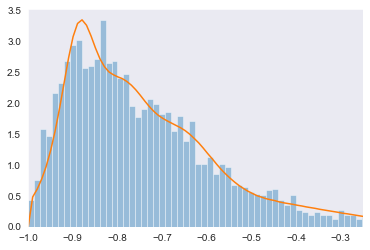

(-1.0, -0.25)

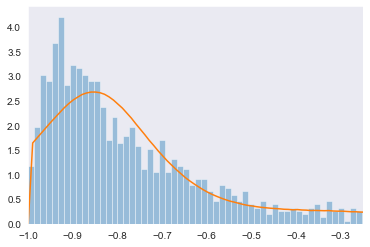

In [259]:
mf_signal.drawDistComparison(9, params={'bins':150})
plt.xlim(-1,-0.25)
plt.show()
mf_background.drawDistComparison(9, params={'bins':150})
plt.xlim(-1,-0.25)

In [126]:
len(background_data[feat])

6858

# Fitting the signal data

In [262]:
compileArgs = {'loss':'mean_squared_error', 
          'optimizer':'Adam'}
    

trainParams = {'epochs' : 150,
            'batch_size' : 10, 
                'verbose' : 2}

Train on 1274 samples
Epoch 1/150
1274/1274 - 1s - loss: 0.4693
Epoch 2/150
1274/1274 - 0s - loss: 0.2245
Epoch 3/150
1274/1274 - 0s - loss: 0.1918
Epoch 4/150
1274/1274 - 0s - loss: 0.1880
Epoch 5/150
1274/1274 - 0s - loss: 0.1843
Epoch 6/150
1274/1274 - 0s - loss: 0.1797
Epoch 7/150
1274/1274 - 0s - loss: 0.1735
Epoch 8/150
1274/1274 - 0s - loss: 0.1656
Epoch 9/150
1274/1274 - 0s - loss: 0.1552
Epoch 10/150
1274/1274 - 0s - loss: 0.1404
Epoch 11/150
1274/1274 - 0s - loss: 0.1228
Epoch 12/150
1274/1274 - 0s - loss: 0.1045
Epoch 13/150
1274/1274 - 0s - loss: 0.0868
Epoch 14/150
1274/1274 - 0s - loss: 0.0702
Epoch 15/150
1274/1274 - 0s - loss: 0.0556
Epoch 16/150
1274/1274 - 0s - loss: 0.0430
Epoch 17/150
1274/1274 - 0s - loss: 0.0327
Epoch 18/150
1274/1274 - 0s - loss: 0.0243
Epoch 19/150
1274/1274 - 0s - loss: 0.0177
Epoch 20/150
1274/1274 - 0s - loss: 0.0127
Epoch 21/150
1274/1274 - 0s - loss: 0.0091
Epoch 22/150
1274/1274 - 0s - loss: 0.0065
Epoch 23/150
1274/1274 - 0s - loss: 0.004

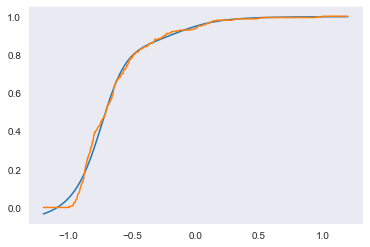

Train on 1274 samples
Epoch 1/150
1274/1274 - 1s - loss: 0.3416
Epoch 2/150
1274/1274 - 0s - loss: 0.2008
Epoch 3/150
1274/1274 - 0s - loss: 0.1931
Epoch 4/150
1274/1274 - 0s - loss: 0.1905
Epoch 5/150
1274/1274 - 0s - loss: 0.1873
Epoch 6/150
1274/1274 - 0s - loss: 0.1824
Epoch 7/150
1274/1274 - 0s - loss: 0.1756
Epoch 8/150
1274/1274 - 0s - loss: 0.1662
Epoch 9/150
1274/1274 - 0s - loss: 0.1506
Epoch 10/150
1274/1274 - 0s - loss: 0.1286
Epoch 11/150
1274/1274 - 0s - loss: 0.1053
Epoch 12/150
1274/1274 - 0s - loss: 0.0839
Epoch 13/150
1274/1274 - 0s - loss: 0.0651
Epoch 14/150
1274/1274 - 0s - loss: 0.0489
Epoch 15/150
1274/1274 - 0s - loss: 0.0357
Epoch 16/150
1274/1274 - 0s - loss: 0.0253
Epoch 17/150
1274/1274 - 0s - loss: 0.0176
Epoch 18/150
1274/1274 - 0s - loss: 0.0121
Epoch 19/150
1274/1274 - 0s - loss: 0.0082
Epoch 20/150
1274/1274 - 0s - loss: 0.0056
Epoch 21/150
1274/1274 - 0s - loss: 0.0039
Epoch 22/150
1274/1274 - 0s - loss: 0.0028
Epoch 23/150
1274/1274 - 0s - loss: 0.002

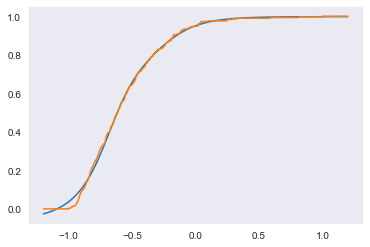

Train on 1274 samples
Epoch 1/150
1274/1274 - 1s - loss: 0.4359
Epoch 2/150
1274/1274 - 0s - loss: 0.2189
Epoch 3/150
1274/1274 - 0s - loss: 0.1902
Epoch 4/150
1274/1274 - 0s - loss: 0.1866
Epoch 5/150
1274/1274 - 0s - loss: 0.1832
Epoch 6/150
1274/1274 - 0s - loss: 0.1778
Epoch 7/150
1274/1274 - 0s - loss: 0.1693
Epoch 8/150
1274/1274 - 0s - loss: 0.1556
Epoch 9/150
1274/1274 - 0s - loss: 0.1362
Epoch 10/150
1274/1274 - 0s - loss: 0.1133
Epoch 11/150
1274/1274 - 0s - loss: 0.0907
Epoch 12/150
1274/1274 - 0s - loss: 0.0702
Epoch 13/150
1274/1274 - 0s - loss: 0.0526
Epoch 14/150
1274/1274 - 0s - loss: 0.0382
Epoch 15/150
1274/1274 - 0s - loss: 0.0271
Epoch 16/150
1274/1274 - 0s - loss: 0.0189
Epoch 17/150
1274/1274 - 0s - loss: 0.0133
Epoch 18/150
1274/1274 - 0s - loss: 0.0094
Epoch 19/150
1274/1274 - 0s - loss: 0.0070
Epoch 20/150
1274/1274 - 0s - loss: 0.0054
Epoch 21/150
1274/1274 - 0s - loss: 0.0044
Epoch 22/150
1274/1274 - 0s - loss: 0.0038
Epoch 23/150
1274/1274 - 0s - loss: 0.003

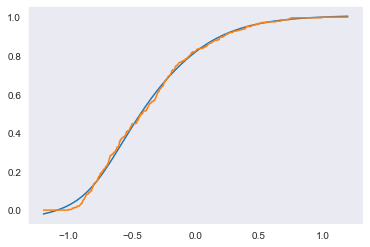

Train on 1274 samples
Epoch 1/150
1274/1274 - 1s - loss: 0.3638
Epoch 2/150
1274/1274 - 0s - loss: 0.2025
Epoch 3/150
1274/1274 - 0s - loss: 0.1939
Epoch 4/150
1274/1274 - 0s - loss: 0.1918
Epoch 5/150
1274/1274 - 0s - loss: 0.1885
Epoch 6/150
1274/1274 - 0s - loss: 0.1847
Epoch 7/150
1274/1274 - 0s - loss: 0.1791
Epoch 8/150
1274/1274 - 0s - loss: 0.1720
Epoch 9/150
1274/1274 - 0s - loss: 0.1625
Epoch 10/150
1274/1274 - 0s - loss: 0.1485
Epoch 11/150
1274/1274 - 0s - loss: 0.1279
Epoch 12/150
1274/1274 - 0s - loss: 0.1018
Epoch 13/150
1274/1274 - 0s - loss: 0.0734
Epoch 14/150
1274/1274 - 0s - loss: 0.0487
Epoch 15/150
1274/1274 - 0s - loss: 0.0303
Epoch 16/150
1274/1274 - 0s - loss: 0.0180
Epoch 17/150
1274/1274 - 0s - loss: 0.0104
Epoch 18/150
1274/1274 - 0s - loss: 0.0059
Epoch 19/150
1274/1274 - 0s - loss: 0.0034
Epoch 20/150
1274/1274 - 0s - loss: 0.0021
Epoch 21/150
1274/1274 - 0s - loss: 0.0015
Epoch 22/150
1274/1274 - 0s - loss: 0.0011
Epoch 23/150
1274/1274 - 0s - loss: 9.360

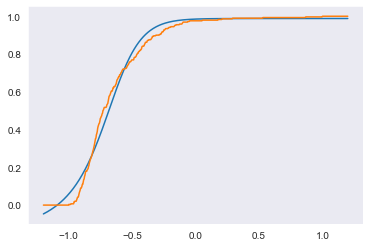

Train on 1274 samples
Epoch 1/150
1274/1274 - 1s - loss: 0.3399
Epoch 2/150
1274/1274 - 0s - loss: 0.1890
Epoch 3/150
1274/1274 - 0s - loss: 0.1776
Epoch 4/150
1274/1274 - 0s - loss: 0.1647
Epoch 5/150
1274/1274 - 0s - loss: 0.1393
Epoch 6/150
1274/1274 - 0s - loss: 0.1138
Epoch 7/150
1274/1274 - 0s - loss: 0.0921
Epoch 8/150
1274/1274 - 0s - loss: 0.0735
Epoch 9/150
1274/1274 - 0s - loss: 0.0573
Epoch 10/150
1274/1274 - 0s - loss: 0.0435
Epoch 11/150
1274/1274 - 0s - loss: 0.0322
Epoch 12/150
1274/1274 - 0s - loss: 0.0235
Epoch 13/150
1274/1274 - 0s - loss: 0.0171
Epoch 14/150
1274/1274 - 0s - loss: 0.0126
Epoch 15/150
1274/1274 - 0s - loss: 0.0096
Epoch 16/150
1274/1274 - 0s - loss: 0.0076
Epoch 17/150
1274/1274 - 0s - loss: 0.0063
Epoch 18/150
1274/1274 - 0s - loss: 0.0053
Epoch 19/150
1274/1274 - 0s - loss: 0.0044
Epoch 20/150
1274/1274 - 0s - loss: 0.0033
Epoch 21/150
1274/1274 - 0s - loss: 0.0023
Epoch 22/150
1274/1274 - 0s - loss: 0.0015
Epoch 23/150
1274/1274 - 0s - loss: 9.098

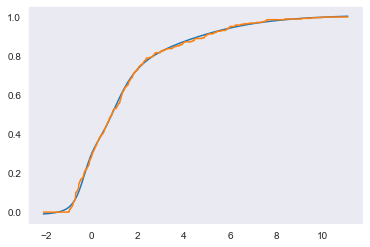

Train on 1274 samples
Epoch 1/150
1274/1274 - 1s - loss: 0.4466
Epoch 2/150
1274/1274 - 0s - loss: 0.2141
Epoch 3/150
1274/1274 - 0s - loss: 0.1881
Epoch 4/150
1274/1274 - 0s - loss: 0.1849
Epoch 5/150
1274/1274 - 0s - loss: 0.1815
Epoch 6/150
1274/1274 - 0s - loss: 0.1773
Epoch 7/150
1274/1274 - 0s - loss: 0.1720
Epoch 8/150
1274/1274 - 0s - loss: 0.1654
Epoch 9/150
1274/1274 - 0s - loss: 0.1571
Epoch 10/150
1274/1274 - 0s - loss: 0.1462
Epoch 11/150
1274/1274 - 0s - loss: 0.1317
Epoch 12/150
1274/1274 - 0s - loss: 0.1143
Epoch 13/150
1274/1274 - 0s - loss: 0.0973
Epoch 14/150
1274/1274 - 0s - loss: 0.0809
Epoch 15/150
1274/1274 - 0s - loss: 0.0660
Epoch 16/150
1274/1274 - 0s - loss: 0.0529
Epoch 17/150
1274/1274 - 0s - loss: 0.0417
Epoch 18/150
1274/1274 - 0s - loss: 0.0324
Epoch 19/150
1274/1274 - 0s - loss: 0.0248
Epoch 20/150
1274/1274 - 0s - loss: 0.0188
Epoch 21/150
1274/1274 - 0s - loss: 0.0142
Epoch 22/150
1274/1274 - 0s - loss: 0.0106
Epoch 23/150
1274/1274 - 0s - loss: 0.008

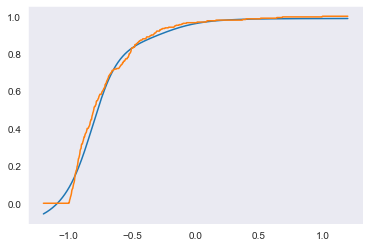

Train on 1274 samples
Epoch 1/150
1274/1274 - 1s - loss: 0.4093
Epoch 2/150
1274/1274 - 0s - loss: 0.2062
Epoch 3/150
1274/1274 - 0s - loss: 0.1905
Epoch 4/150
1274/1274 - 0s - loss: 0.1876
Epoch 5/150
1274/1274 - 0s - loss: 0.1842
Epoch 6/150
1274/1274 - 0s - loss: 0.1798
Epoch 7/150
1274/1274 - 0s - loss: 0.1741
Epoch 8/150
1274/1274 - 0s - loss: 0.1676
Epoch 9/150
1274/1274 - 0s - loss: 0.1589
Epoch 10/150
1274/1274 - 0s - loss: 0.1485
Epoch 11/150
1274/1274 - 0s - loss: 0.1345
Epoch 12/150
1274/1274 - 0s - loss: 0.1168
Epoch 13/150
1274/1274 - 0s - loss: 0.0971
Epoch 14/150
1274/1274 - 0s - loss: 0.0784
Epoch 15/150
1274/1274 - 0s - loss: 0.0615
Epoch 16/150
1274/1274 - 0s - loss: 0.0473
Epoch 17/150
1274/1274 - 0s - loss: 0.0356
Epoch 18/150
1274/1274 - 0s - loss: 0.0264
Epoch 19/150
1274/1274 - 0s - loss: 0.0194
Epoch 20/150
1274/1274 - 0s - loss: 0.0140
Epoch 21/150
1274/1274 - 0s - loss: 0.0100
Epoch 22/150
1274/1274 - 0s - loss: 0.0072
Epoch 23/150
1274/1274 - 0s - loss: 0.005

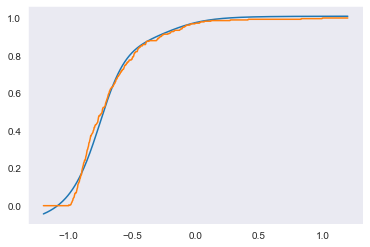

Train on 1274 samples
Epoch 1/150
1274/1274 - 1s - loss: 0.4234
Epoch 2/150
1274/1274 - 0s - loss: 0.2118
Epoch 3/150
1274/1274 - 0s - loss: 0.1941
Epoch 4/150
1274/1274 - 0s - loss: 0.1913
Epoch 5/150
1274/1274 - 0s - loss: 0.1880
Epoch 6/150
1274/1274 - 0s - loss: 0.1837
Epoch 7/150
1274/1274 - 0s - loss: 0.1786
Epoch 8/150
1274/1274 - 0s - loss: 0.1718
Epoch 9/150
1274/1274 - 0s - loss: 0.1637
Epoch 10/150
1274/1274 - 0s - loss: 0.1540
Epoch 11/150
1274/1274 - 0s - loss: 0.1417
Epoch 12/150
1274/1274 - 0s - loss: 0.1248
Epoch 13/150
1274/1274 - 0s - loss: 0.1039
Epoch 14/150
1274/1274 - 0s - loss: 0.0837
Epoch 15/150
1274/1274 - 0s - loss: 0.0667
Epoch 16/150
1274/1274 - 0s - loss: 0.0523
Epoch 17/150
1274/1274 - 0s - loss: 0.0402
Epoch 18/150
1274/1274 - 0s - loss: 0.0304
Epoch 19/150
1274/1274 - 0s - loss: 0.0226
Epoch 20/150
1274/1274 - 0s - loss: 0.0165
Epoch 21/150
1274/1274 - 0s - loss: 0.0119
Epoch 22/150
1274/1274 - 0s - loss: 0.0084
Epoch 23/150
1274/1274 - 0s - loss: 0.005

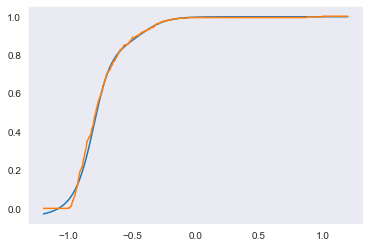

Train on 1274 samples
Epoch 1/150
1274/1274 - 1s - loss: 0.5005
Epoch 2/150
1274/1274 - 0s - loss: 0.2259
Epoch 3/150
1274/1274 - 0s - loss: 0.1889
Epoch 4/150
1274/1274 - 0s - loss: 0.1853
Epoch 5/150
1274/1274 - 0s - loss: 0.1818
Epoch 6/150
1274/1274 - 0s - loss: 0.1776
Epoch 7/150
1274/1274 - 0s - loss: 0.1721
Epoch 8/150
1274/1274 - 0s - loss: 0.1661
Epoch 9/150
1274/1274 - 0s - loss: 0.1573
Epoch 10/150
1274/1274 - 0s - loss: 0.1460
Epoch 11/150
1274/1274 - 0s - loss: 0.1316
Epoch 12/150
1274/1274 - 0s - loss: 0.1163
Epoch 13/150
1274/1274 - 0s - loss: 0.1008
Epoch 14/150
1274/1274 - 0s - loss: 0.0860
Epoch 15/150
1274/1274 - 0s - loss: 0.0724
Epoch 16/150
1274/1274 - 0s - loss: 0.0600
Epoch 17/150
1274/1274 - 0s - loss: 0.0491
Epoch 18/150
1274/1274 - 0s - loss: 0.0397
Epoch 19/150
1274/1274 - 0s - loss: 0.0318
Epoch 20/150
1274/1274 - 0s - loss: 0.0252
Epoch 21/150
1274/1274 - 0s - loss: 0.0199
Epoch 22/150
1274/1274 - 0s - loss: 0.0155
Epoch 23/150
1274/1274 - 0s - loss: 0.012

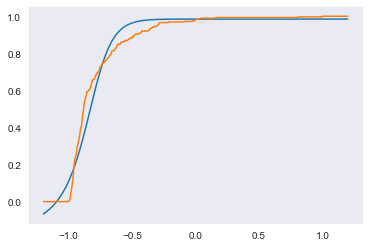

Train on 1274 samples
Epoch 1/150
1274/1274 - 1s - loss: 0.3557
Epoch 2/150
1274/1274 - 0s - loss: 0.1985
Epoch 3/150
1274/1274 - 0s - loss: 0.1894
Epoch 4/150
1274/1274 - 0s - loss: 0.1865
Epoch 5/150
1274/1274 - 0s - loss: 0.1836
Epoch 6/150
1274/1274 - 0s - loss: 0.1787
Epoch 7/150
1274/1274 - 0s - loss: 0.1721
Epoch 8/150
1274/1274 - 0s - loss: 0.1616
Epoch 9/150
1274/1274 - 0s - loss: 0.1472
Epoch 10/150
1274/1274 - 0s - loss: 0.1292
Epoch 11/150
1274/1274 - 0s - loss: 0.1094
Epoch 12/150
1274/1274 - 0s - loss: 0.0891
Epoch 13/150
1274/1274 - 0s - loss: 0.0708
Epoch 14/150
1274/1274 - 0s - loss: 0.0548
Epoch 15/150
1274/1274 - 0s - loss: 0.0415
Epoch 16/150
1274/1274 - 0s - loss: 0.0309
Epoch 17/150
1274/1274 - 0s - loss: 0.0225
Epoch 18/150
1274/1274 - 0s - loss: 0.0162
Epoch 19/150
1274/1274 - 0s - loss: 0.0116
Epoch 20/150
1274/1274 - 0s - loss: 0.0084
Epoch 21/150
1274/1274 - 0s - loss: 0.0061
Epoch 22/150
1274/1274 - 0s - loss: 0.0045
Epoch 23/150
1274/1274 - 0s - loss: 0.003

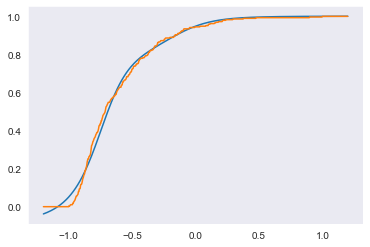

Train on 1274 samples
Epoch 1/150
1274/1274 - 1s - loss: 0.3640
Epoch 2/150
1274/1274 - 0s - loss: 0.2019
Epoch 3/150
1274/1274 - 0s - loss: 0.1944
Epoch 4/150
1274/1274 - 0s - loss: 0.1918
Epoch 5/150
1274/1274 - 0s - loss: 0.1888
Epoch 6/150
1274/1274 - 0s - loss: 0.1843
Epoch 7/150
1274/1274 - 0s - loss: 0.1786
Epoch 8/150
1274/1274 - 0s - loss: 0.1712
Epoch 9/150
1274/1274 - 0s - loss: 0.1627
Epoch 10/150
1274/1274 - 0s - loss: 0.1522
Epoch 11/150
1274/1274 - 0s - loss: 0.1389
Epoch 12/150
1274/1274 - 0s - loss: 0.1208
Epoch 13/150
1274/1274 - 0s - loss: 0.1002
Epoch 14/150
1274/1274 - 0s - loss: 0.0791
Epoch 15/150
1274/1274 - 0s - loss: 0.0614
Epoch 16/150
1274/1274 - 0s - loss: 0.0468
Epoch 17/150
1274/1274 - 0s - loss: 0.0351
Epoch 18/150
1274/1274 - 0s - loss: 0.0258
Epoch 19/150
1274/1274 - 0s - loss: 0.0186
Epoch 20/150
1274/1274 - 0s - loss: 0.0131
Epoch 21/150
1274/1274 - 0s - loss: 0.0091
Epoch 22/150
1274/1274 - 0s - loss: 0.0062
Epoch 23/150
1274/1274 - 0s - loss: 0.004

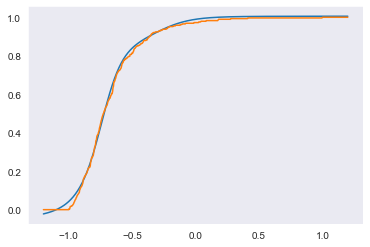

Train on 1274 samples
Epoch 1/150
1274/1274 - 1s - loss: 0.2392
Epoch 2/150
1274/1274 - 0s - loss: 0.1844
Epoch 3/150
1274/1274 - 0s - loss: 0.1825
Epoch 4/150
1274/1274 - 0s - loss: 0.1808
Epoch 5/150
1274/1274 - 0s - loss: 0.1781
Epoch 6/150
1274/1274 - 0s - loss: 0.1726
Epoch 7/150
1274/1274 - 0s - loss: 0.1617
Epoch 8/150
1274/1274 - 0s - loss: 0.1435
Epoch 9/150
1274/1274 - 0s - loss: 0.1191
Epoch 10/150
1274/1274 - 0s - loss: 0.0931
Epoch 11/150
1274/1274 - 0s - loss: 0.0688
Epoch 12/150
1274/1274 - 0s - loss: 0.0478
Epoch 13/150
1274/1274 - 0s - loss: 0.0316
Epoch 14/150
1274/1274 - 0s - loss: 0.0204
Epoch 15/150
1274/1274 - 0s - loss: 0.0133
Epoch 16/150
1274/1274 - 0s - loss: 0.0091
Epoch 17/150
1274/1274 - 0s - loss: 0.0068
Epoch 18/150
1274/1274 - 0s - loss: 0.0055
Epoch 19/150
1274/1274 - 0s - loss: 0.0047
Epoch 20/150
1274/1274 - 0s - loss: 0.0041
Epoch 21/150
1274/1274 - 0s - loss: 0.0035
Epoch 22/150
1274/1274 - 0s - loss: 0.0029
Epoch 23/150
1274/1274 - 0s - loss: 0.002

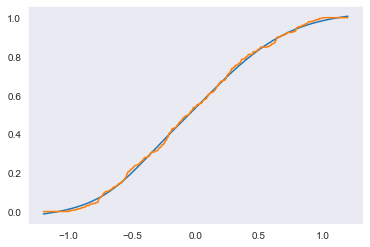

Train on 1274 samples
Epoch 1/150
1274/1274 - 1s - loss: 0.3068
Epoch 2/150
1274/1274 - 0s - loss: 0.2060
Epoch 3/150
1274/1274 - 0s - loss: 0.2024
Epoch 4/150
1274/1274 - 0s - loss: 0.1999
Epoch 5/150
1274/1274 - 0s - loss: 0.1967
Epoch 6/150
1274/1274 - 0s - loss: 0.1919
Epoch 7/150
1274/1274 - 0s - loss: 0.1849
Epoch 8/150
1274/1274 - 0s - loss: 0.1729
Epoch 9/150
1274/1274 - 0s - loss: 0.1524
Epoch 10/150
1274/1274 - 0s - loss: 0.1242
Epoch 11/150
1274/1274 - 0s - loss: 0.0947
Epoch 12/150
1274/1274 - 0s - loss: 0.0676
Epoch 13/150
1274/1274 - 0s - loss: 0.0451
Epoch 14/150
1274/1274 - 0s - loss: 0.0283
Epoch 15/150
1274/1274 - 0s - loss: 0.0170
Epoch 16/150
1274/1274 - 0s - loss: 0.0099
Epoch 17/150
1274/1274 - 0s - loss: 0.0058
Epoch 18/150
1274/1274 - 0s - loss: 0.0036
Epoch 19/150
1274/1274 - 0s - loss: 0.0024
Epoch 20/150
1274/1274 - 0s - loss: 0.0018
Epoch 21/150
1274/1274 - 0s - loss: 0.0015
Epoch 22/150
1274/1274 - 0s - loss: 0.0013
Epoch 23/150
1274/1274 - 0s - loss: 0.001

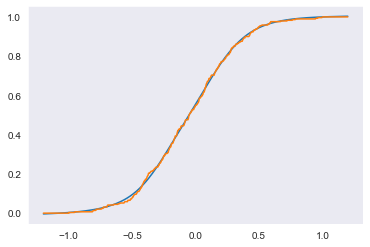

Train on 1274 samples
Epoch 1/150
1274/1274 - 1s - loss: 0.3042
Epoch 2/150
1274/1274 - 0s - loss: 0.2074
Epoch 3/150
1274/1274 - 0s - loss: 0.2035
Epoch 4/150
1274/1274 - 0s - loss: 0.2016
Epoch 5/150
1274/1274 - 0s - loss: 0.1989
Epoch 6/150
1274/1274 - 0s - loss: 0.1947
Epoch 7/150
1274/1274 - 0s - loss: 0.1889
Epoch 8/150
1274/1274 - 0s - loss: 0.1801
Epoch 9/150
1274/1274 - 0s - loss: 0.1657
Epoch 10/150
1274/1274 - 0s - loss: 0.1418
Epoch 11/150
1274/1274 - 0s - loss: 0.1116
Epoch 12/150
1274/1274 - 0s - loss: 0.0813
Epoch 13/150
1274/1274 - 0s - loss: 0.0551
Epoch 14/150
1274/1274 - 0s - loss: 0.0352
Epoch 15/150
1274/1274 - 0s - loss: 0.0209
Epoch 16/150
1274/1274 - 0s - loss: 0.0119
Epoch 17/150
1274/1274 - 0s - loss: 0.0065
Epoch 18/150
1274/1274 - 0s - loss: 0.0036
Epoch 19/150
1274/1274 - 0s - loss: 0.0021
Epoch 20/150
1274/1274 - 0s - loss: 0.0014
Epoch 21/150
1274/1274 - 0s - loss: 0.0010
Epoch 22/150
1274/1274 - 0s - loss: 8.6483e-04
Epoch 23/150
1274/1274 - 0s - loss: 7

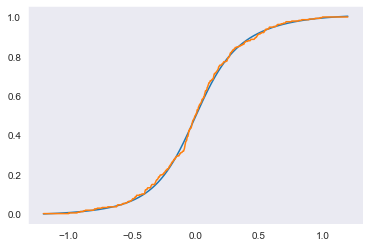

In [263]:
fitParams0 = {'verbose':2, 
             'xrange_excess': 0.2,
             'density': 2,
             'edge_density_mult':3}

mf_signal = MultiFeature(FullSignal_file, feature_names, 
                         parameters={'trainParams': trainParams, 'compileArgs':compileArgs}, xrange=(-1, 1))
mf_signal.normalise_range(4, (-1,10))

# mf_signal.get_distribuitions_from_file(filename) // folder containing "features".h5
mf_signal.fitAll(fitParams0)


8  Daughter2 Total Momentum (GeV/c)
Train on 1650 samples
Epoch 1/150
1650/1650 - 1s - loss: 0.7280
Epoch 2/150
1650/1650 - 0s - loss: 0.5766
Epoch 3/150
1650/1650 - 0s - loss: 0.4540
Epoch 4/150
1650/1650 - 0s - loss: 0.3525
Epoch 5/150
1650/1650 - 0s - loss: 0.2727
Epoch 6/150
1650/1650 - 0s - loss: 0.2185
Epoch 7/150
1650/1650 - 0s - loss: 0.1895
Epoch 8/150
1650/1650 - 0s - loss: 0.1773
Epoch 9/150
1650/1650 - 0s - loss: 0.1726
Epoch 10/150
1650/1650 - 0s - loss: 0.1705
Epoch 11/150
1650/1650 - 0s - loss: 0.1687
Epoch 12/150
1650/1650 - 0s - loss: 0.1672
Epoch 13/150
1650/1650 - 0s - loss: 0.1657
Epoch 14/150
1650/1650 - 0s - loss: 0.1642
Epoch 15/150
1650/1650 - 0s - loss: 0.1626
Epoch 16/150
1650/1650 - 0s - loss: 0.1610
Epoch 17/150
1650/1650 - 0s - loss: 0.1592
Epoch 18/150
1650/1650 - 0s - loss: 0.1571
Epoch 19/150
1650/1650 - 0s - loss: 0.1547
Epoch 20/150
1650/1650 - 0s - loss: 0.1519
Epoch 21/150
1650/1650 - 0s - loss: 0.1487
Epoch 22/150
1650/1650 - 0s - loss: 0.1452
Epoch

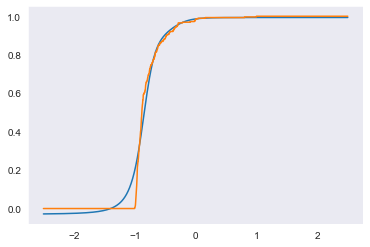

In [298]:
refit_params = {'verbose':2, 
                'xrange_excess': 1.5,
                'density': 3,
                'edge_density_mult':0.3}

refit_train = {'epochs' : 150,
            'batch_size' : 50, 
                'verbose' : 2}

refit_array = [8]
# shady: 5, 7
# mf_signal.normalise_range(4, (-1,10))
for k in refit_array:
    print(k, feature_names[k])
    mf_signal.resetFit(k)
    mf_signal.fitFeature(k, refit_params, refit_train)
    plt.show()
    # mf_signal.drawDistComparison(k)
    # plt.show()


Showing Distribuition results

8  Daughter2 Total Momentum (GeV/c)


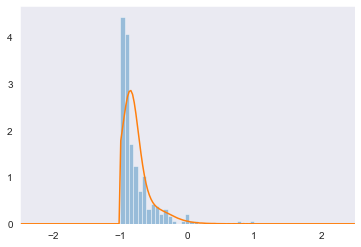

In [299]:
for k in refit_array:
    print(k, feature_names[k])
    mf_signal.drawDistComparison(k)
    plt.show()

0 Mother Total Momentum (GeV/c)


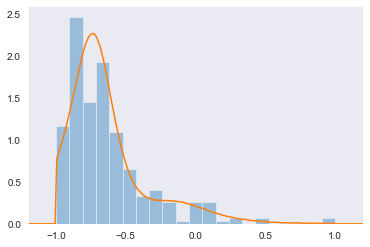

1  Mother Transverse Momentum (GeV/c)


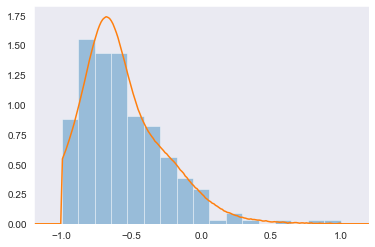

2  Mother Fraction of Transverse Momentum


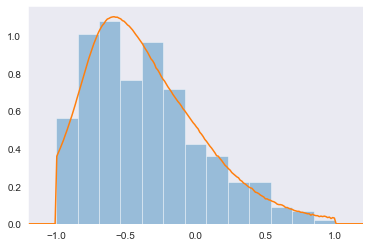

3  Opening Angle (rad)


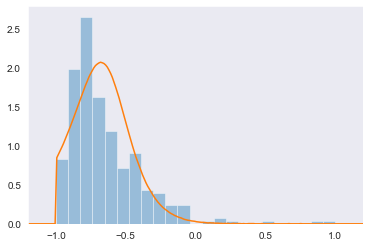

4  Impact Parameter (cm)


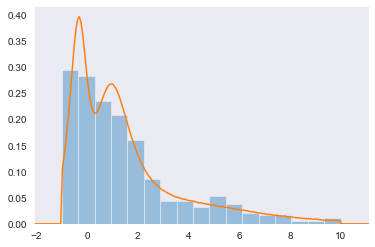

5  Daughter1 Total Momentum (GeV/c)


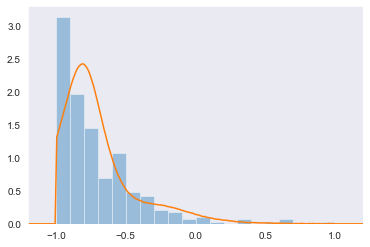

6  Daughter1 Transverse Momentum (GeV/c)


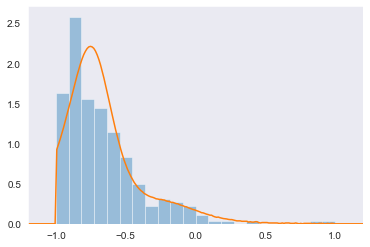

7  Daughter1 Fraction of Transverse Momentum


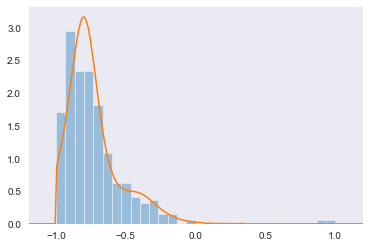

8  Daughter2 Total Momentum (GeV/c)


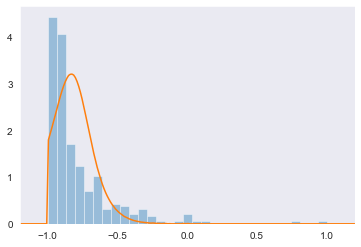

9  Daughter2 Transverse Momentum (GeV/c)


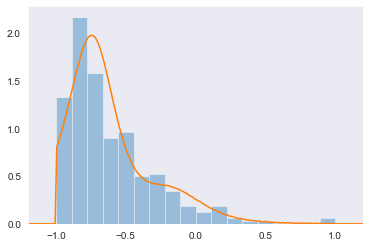

10  Daughter2 Fraction of Transverse Momentum


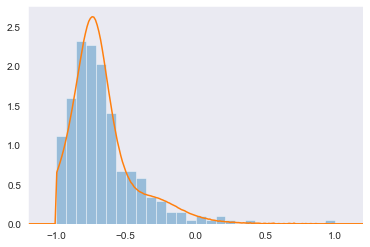

11  Decay Z (cm)


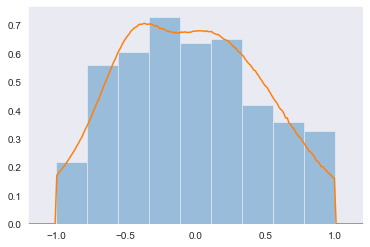

12  Decay X (cm)


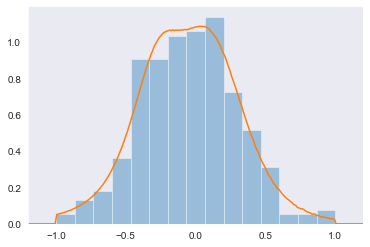

13  Decay Y (cm)


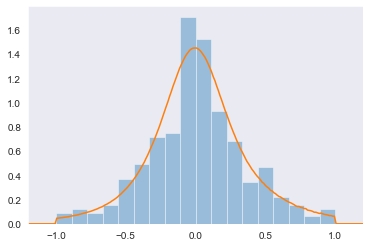

In [293]:
for k, feat in enumerate(feature_names):
    print(k, feat)
    # mf_signal.distfit_array[feat].plotIntegratedComparison()
    mf_signal.drawDistComparison(k)
    plt.show()

Saving the fitting

In [300]:
dirname = "Network Saves/"
filename = "{}/signal-4-{}/".format(dirname, decay_select['decay'])

mf_signal.save_distribuitions_to_file(filename)

# Fitting the background data

In [264]:
trainParams = {'epochs' : 150,
            'batch_size' : 10, 
                'verbose' : 2}

Train on 5462 samples
Epoch 1/150
5462/5462 - 1s - loss: 0.2755
Epoch 2/150
5462/5462 - 1s - loss: 0.1785
Epoch 3/150
5462/5462 - 1s - loss: 0.1474
Epoch 4/150
5462/5462 - 1s - loss: 0.0954
Epoch 5/150
5462/5462 - 1s - loss: 0.0454
Epoch 6/150
5462/5462 - 1s - loss: 0.0187
Epoch 7/150
5462/5462 - 1s - loss: 0.0074
Epoch 8/150
5462/5462 - 1s - loss: 0.0035
Epoch 9/150
5462/5462 - 1s - loss: 0.0023
Epoch 10/150
5462/5462 - 1s - loss: 0.0020
Epoch 11/150
5462/5462 - 1s - loss: 0.0019
Epoch 12/150
5462/5462 - 1s - loss: 0.0019
Epoch 13/150
5462/5462 - 1s - loss: 0.0018
Epoch 14/150
5462/5462 - 1s - loss: 0.0018
Epoch 15/150
5462/5462 - 1s - loss: 0.0017
Epoch 16/150
5462/5462 - 1s - loss: 0.0017
Epoch 17/150
5462/5462 - 1s - loss: 0.0016
Epoch 18/150
5462/5462 - 1s - loss: 0.0016
Epoch 19/150
5462/5462 - 1s - loss: 0.0016
Epoch 20/150
5462/5462 - 1s - loss: 0.0015
Epoch 21/150
5462/5462 - 1s - loss: 0.0015
Epoch 22/150
5462/5462 - 1s - loss: 0.0015
Epoch 23/150
5462/5462 - 1s - loss: 0.001

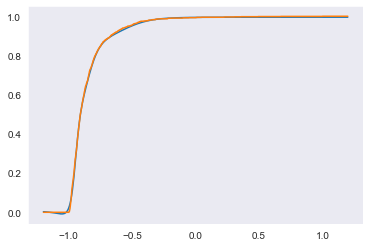

Train on 5462 samples
Epoch 1/150
5462/5462 - 1s - loss: 0.2393
Epoch 2/150
5462/5462 - 1s - loss: 0.1778
Epoch 3/150
5462/5462 - 1s - loss: 0.1250
Epoch 4/150
5462/5462 - 1s - loss: 0.0674
Epoch 5/150
5462/5462 - 1s - loss: 0.0299
Epoch 6/150
5462/5462 - 1s - loss: 0.0119
Epoch 7/150
5462/5462 - 1s - loss: 0.0050
Epoch 8/150
5462/5462 - 1s - loss: 0.0029
Epoch 9/150
5462/5462 - 1s - loss: 0.0024
Epoch 10/150
5462/5462 - 1s - loss: 0.0022
Epoch 11/150
5462/5462 - 1s - loss: 0.0021
Epoch 12/150
5462/5462 - 1s - loss: 0.0020
Epoch 13/150
5462/5462 - 1s - loss: 0.0020
Epoch 14/150
5462/5462 - 1s - loss: 0.0019
Epoch 15/150
5462/5462 - 1s - loss: 0.0019
Epoch 16/150
5462/5462 - 1s - loss: 0.0018
Epoch 17/150
5462/5462 - 1s - loss: 0.0017
Epoch 18/150
5462/5462 - 1s - loss: 0.0017
Epoch 19/150
5462/5462 - 1s - loss: 0.0016
Epoch 20/150
5462/5462 - 1s - loss: 0.0016
Epoch 21/150
5462/5462 - 1s - loss: 0.0015
Epoch 22/150
5462/5462 - 1s - loss: 0.0015
Epoch 23/150
5462/5462 - 1s - loss: 0.001

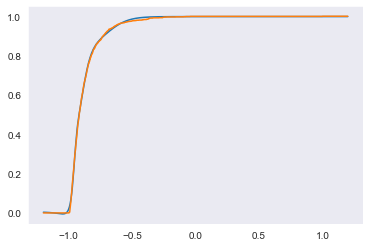

Train on 5462 samples
Epoch 1/150
5462/5462 - 2s - loss: 0.2522
Epoch 2/150
5462/5462 - 1s - loss: 0.1835
Epoch 3/150
5462/5462 - 1s - loss: 0.1539
Epoch 4/150
5462/5462 - 1s - loss: 0.1085
Epoch 5/150
5462/5462 - 1s - loss: 0.0617
Epoch 6/150
5462/5462 - 1s - loss: 0.0287
Epoch 7/150
5462/5462 - 1s - loss: 0.0125
Epoch 8/150
5462/5462 - 1s - loss: 0.0060
Epoch 9/150
5462/5462 - 1s - loss: 0.0038
Epoch 10/150
5462/5462 - 1s - loss: 0.0032
Epoch 11/150
5462/5462 - 1s - loss: 0.0029
Epoch 12/150
5462/5462 - 1s - loss: 0.0028
Epoch 13/150
5462/5462 - 1s - loss: 0.0027
Epoch 14/150
5462/5462 - 1s - loss: 0.0025
Epoch 15/150
5462/5462 - 1s - loss: 0.0024
Epoch 16/150
5462/5462 - 1s - loss: 0.0023
Epoch 17/150
5462/5462 - 1s - loss: 0.0022
Epoch 18/150
5462/5462 - 1s - loss: 0.0020
Epoch 19/150
5462/5462 - 1s - loss: 0.0020
Epoch 20/150
5462/5462 - 1s - loss: 0.0019
Epoch 21/150
5462/5462 - 1s - loss: 0.0018
Epoch 22/150
5462/5462 - 1s - loss: 0.0017
Epoch 23/150
5462/5462 - 1s - loss: 0.001

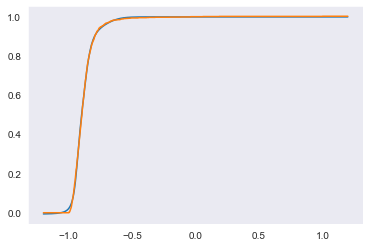

Train on 5462 samples
Epoch 1/150
5462/5462 - 1s - loss: 0.2401
Epoch 2/150
5462/5462 - 1s - loss: 0.1794
Epoch 3/150
5462/5462 - 1s - loss: 0.1394
Epoch 4/150
5462/5462 - 1s - loss: 0.0746
Epoch 5/150
5462/5462 - 1s - loss: 0.0298
Epoch 6/150
5462/5462 - 1s - loss: 0.0096
Epoch 7/150
5462/5462 - 1s - loss: 0.0029
Epoch 8/150
5462/5462 - 1s - loss: 0.0013
Epoch 9/150
5462/5462 - 1s - loss: 0.0010
Epoch 10/150
5462/5462 - 1s - loss: 9.6680e-04
Epoch 11/150
5462/5462 - 1s - loss: 9.4631e-04
Epoch 12/150
5462/5462 - 1s - loss: 9.1351e-04
Epoch 13/150
5462/5462 - 1s - loss: 8.8423e-04
Epoch 14/150
5462/5462 - 1s - loss: 8.5301e-04
Epoch 15/150
5462/5462 - 1s - loss: 8.2927e-04
Epoch 16/150
5462/5462 - 1s - loss: 8.0779e-04
Epoch 17/150
5462/5462 - 1s - loss: 7.9397e-04
Epoch 18/150
5462/5462 - 1s - loss: 7.7069e-04
Epoch 19/150
5462/5462 - 1s - loss: 7.5155e-04
Epoch 20/150
5462/5462 - 1s - loss: 7.2675e-04
Epoch 21/150
5462/5462 - 1s - loss: 7.1023e-04
Epoch 22/150
5462/5462 - 1s - loss: 

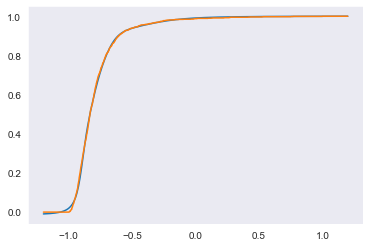

Train on 5462 samples
Epoch 1/150
5462/5462 - 1s - loss: 0.2465
Epoch 2/150
5462/5462 - 1s - loss: 0.1381
Epoch 3/150
5462/5462 - 1s - loss: 0.0617
Epoch 4/150
5462/5462 - 1s - loss: 0.0204
Epoch 5/150
5462/5462 - 1s - loss: 0.0047
Epoch 6/150
5462/5462 - 1s - loss: 0.0010
Epoch 7/150
5462/5462 - 1s - loss: 5.5134e-04
Epoch 8/150
5462/5462 - 1s - loss: 4.9303e-04
Epoch 9/150
5462/5462 - 1s - loss: 4.6462e-04
Epoch 10/150
5462/5462 - 1s - loss: 4.4515e-04
Epoch 11/150
5462/5462 - 1s - loss: 4.2391e-04
Epoch 12/150
5462/5462 - 1s - loss: 4.0582e-04
Epoch 13/150
5462/5462 - 1s - loss: 3.8992e-04
Epoch 14/150
5462/5462 - 1s - loss: 3.7894e-04
Epoch 15/150
5462/5462 - 1s - loss: 3.7151e-04
Epoch 16/150
5462/5462 - 1s - loss: 3.4931e-04
Epoch 17/150
5462/5462 - 1s - loss: 3.2110e-04
Epoch 18/150
5462/5462 - 1s - loss: 2.7135e-04
Epoch 19/150
5462/5462 - 1s - loss: 2.1629e-04
Epoch 20/150
5462/5462 - 1s - loss: 1.7082e-04
Epoch 21/150
5462/5462 - 1s - loss: 1.4563e-04
Epoch 22/150
5462/5462 -

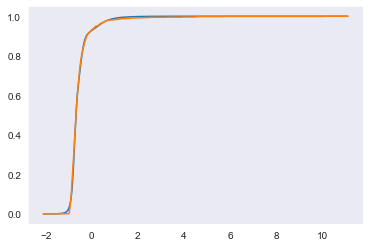

Train on 5462 samples
Epoch 1/150
5462/5462 - 1s - loss: 0.2959
Epoch 2/150
5462/5462 - 1s - loss: 0.1768
Epoch 3/150
5462/5462 - 1s - loss: 0.1327
Epoch 4/150
5462/5462 - 1s - loss: 0.0692
Epoch 5/150
5462/5462 - 1s - loss: 0.0264
Epoch 6/150
5462/5462 - 1s - loss: 0.0112
Epoch 7/150
5462/5462 - 1s - loss: 0.0068
Epoch 8/150
5462/5462 - 1s - loss: 0.0056
Epoch 9/150
5462/5462 - 1s - loss: 0.0052
Epoch 10/150
5462/5462 - 1s - loss: 0.0051
Epoch 11/150
5462/5462 - 1s - loss: 0.0050
Epoch 12/150
5462/5462 - 1s - loss: 0.0049
Epoch 13/150
5462/5462 - 1s - loss: 0.0048
Epoch 14/150
5462/5462 - 1s - loss: 0.0047
Epoch 15/150
5462/5462 - 1s - loss: 0.0046
Epoch 16/150
5462/5462 - 1s - loss: 0.0045
Epoch 17/150
5462/5462 - 1s - loss: 0.0044
Epoch 18/150
5462/5462 - 1s - loss: 0.0043
Epoch 19/150
5462/5462 - 1s - loss: 0.0042
Epoch 20/150
5462/5462 - 1s - loss: 0.0042
Epoch 21/150
5462/5462 - 1s - loss: 0.0041
Epoch 22/150
5462/5462 - 1s - loss: 0.0040
Epoch 23/150
5462/5462 - 1s - loss: 0.003

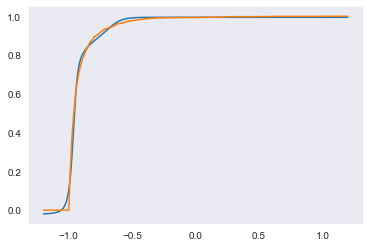

Train on 5462 samples
Epoch 1/150
5462/5462 - 1s - loss: 0.2757
Epoch 2/150
5462/5462 - 1s - loss: 0.1792
Epoch 3/150
5462/5462 - 1s - loss: 0.1413
Epoch 4/150
5462/5462 - 1s - loss: 0.0834
Epoch 5/150
5462/5462 - 1s - loss: 0.0421
Epoch 6/150
5462/5462 - 1s - loss: 0.0194
Epoch 7/150
5462/5462 - 1s - loss: 0.0092
Epoch 8/150
5462/5462 - 1s - loss: 0.0054
Epoch 9/150
5462/5462 - 1s - loss: 0.0041
Epoch 10/150
5462/5462 - 1s - loss: 0.0037
Epoch 11/150
5462/5462 - 1s - loss: 0.0036
Epoch 12/150
5462/5462 - 1s - loss: 0.0035
Epoch 13/150
5462/5462 - 1s - loss: 0.0034
Epoch 14/150
5462/5462 - 1s - loss: 0.0033
Epoch 15/150
5462/5462 - 1s - loss: 0.0032
Epoch 16/150
5462/5462 - 1s - loss: 0.0031
Epoch 17/150
5462/5462 - 1s - loss: 0.0030
Epoch 18/150
5462/5462 - 1s - loss: 0.0029
Epoch 19/150
5462/5462 - 1s - loss: 0.0029
Epoch 20/150
5462/5462 - 1s - loss: 0.0028
Epoch 21/150
5462/5462 - 1s - loss: 0.0027
Epoch 22/150
5462/5462 - 1s - loss: 0.0026
Epoch 23/150
5462/5462 - 1s - loss: 0.002

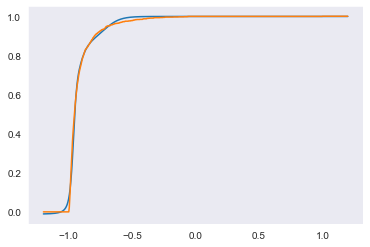

Train on 5462 samples
Epoch 1/150
5462/5462 - 2s - loss: 0.2626
Epoch 2/150
5462/5462 - 1s - loss: 0.1826
Epoch 3/150
5462/5462 - 1s - loss: 0.1476
Epoch 4/150
5462/5462 - 1s - loss: 0.0874
Epoch 5/150
5462/5462 - 1s - loss: 0.0411
Epoch 6/150
5462/5462 - 1s - loss: 0.0167
Epoch 7/150
5462/5462 - 1s - loss: 0.0066
Epoch 8/150
5462/5462 - 1s - loss: 0.0033
Epoch 9/150
5462/5462 - 1s - loss: 0.0024
Epoch 10/150
5462/5462 - 1s - loss: 0.0022
Epoch 11/150
5462/5462 - 1s - loss: 0.0021
Epoch 12/150
5462/5462 - 1s - loss: 0.0020
Epoch 13/150
5462/5462 - 1s - loss: 0.0018
Epoch 14/150
5462/5462 - 1s - loss: 0.0017
Epoch 15/150
5462/5462 - 1s - loss: 0.0016
Epoch 16/150
5462/5462 - 1s - loss: 0.0015
Epoch 17/150
5462/5462 - 1s - loss: 0.0014
Epoch 18/150
5462/5462 - 1s - loss: 0.0013
Epoch 19/150
5462/5462 - 1s - loss: 0.0013
Epoch 20/150
5462/5462 - 1s - loss: 0.0012
Epoch 21/150
5462/5462 - 1s - loss: 0.0011
Epoch 22/150
5462/5462 - 1s - loss: 0.0010
Epoch 23/150
5462/5462 - 1s - loss: 9.696

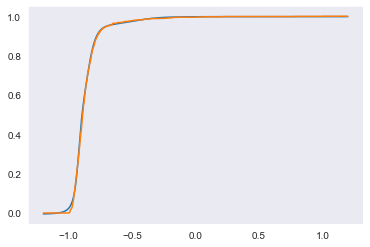

Train on 5462 samples
Epoch 1/150
5462/5462 - 1s - loss: 0.2621
Epoch 2/150
5462/5462 - 1s - loss: 0.1758
Epoch 3/150
5462/5462 - 1s - loss: 0.1449
Epoch 4/150
5462/5462 - 1s - loss: 0.0987
Epoch 5/150
5462/5462 - 1s - loss: 0.0542
Epoch 6/150
5462/5462 - 1s - loss: 0.0262
Epoch 7/150
5462/5462 - 1s - loss: 0.0124
Epoch 8/150
5462/5462 - 1s - loss: 0.0064
Epoch 9/150
5462/5462 - 1s - loss: 0.0040
Epoch 10/150
5462/5462 - 1s - loss: 0.0032
Epoch 11/150
5462/5462 - 1s - loss: 0.0029
Epoch 12/150
5462/5462 - 1s - loss: 0.0028
Epoch 13/150
5462/5462 - 1s - loss: 0.0028
Epoch 14/150
5462/5462 - 1s - loss: 0.0027
Epoch 15/150
5462/5462 - 1s - loss: 0.0027
Epoch 16/150
5462/5462 - 1s - loss: 0.0027
Epoch 17/150
5462/5462 - 1s - loss: 0.0026
Epoch 18/150
5462/5462 - 1s - loss: 0.0026
Epoch 19/150
5462/5462 - 1s - loss: 0.0025
Epoch 20/150
5462/5462 - 1s - loss: 0.0025
Epoch 21/150
5462/5462 - 1s - loss: 0.0025
Epoch 22/150
5462/5462 - 1s - loss: 0.0024
Epoch 23/150
5462/5462 - 1s - loss: 0.002

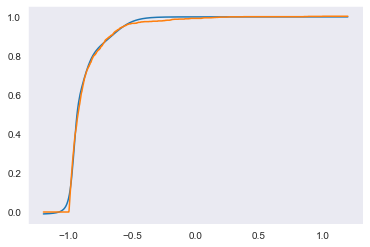

Train on 5462 samples
Epoch 1/150
5462/5462 - 1s - loss: 0.2478
Epoch 2/150
5462/5462 - 1s - loss: 0.1765
Epoch 3/150
5462/5462 - 1s - loss: 0.1379
Epoch 4/150
5462/5462 - 1s - loss: 0.0734
Epoch 5/150
5462/5462 - 1s - loss: 0.0313
Epoch 6/150
5462/5462 - 1s - loss: 0.0116
Epoch 7/150
5462/5462 - 1s - loss: 0.0044
Epoch 8/150
5462/5462 - 1s - loss: 0.0022
Epoch 9/150
5462/5462 - 1s - loss: 0.0017
Epoch 10/150
5462/5462 - 1s - loss: 0.0016
Epoch 11/150
5462/5462 - 1s - loss: 0.0016
Epoch 12/150
5462/5462 - 1s - loss: 0.0015
Epoch 13/150
5462/5462 - 1s - loss: 0.0015
Epoch 14/150
5462/5462 - 1s - loss: 0.0015
Epoch 15/150
5462/5462 - 1s - loss: 0.0015
Epoch 16/150
5462/5462 - 1s - loss: 0.0014
Epoch 17/150
5462/5462 - 1s - loss: 0.0014
Epoch 18/150
5462/5462 - 1s - loss: 0.0014
Epoch 19/150
5462/5462 - 1s - loss: 0.0014
Epoch 20/150
5462/5462 - 1s - loss: 0.0014
Epoch 21/150
5462/5462 - 1s - loss: 0.0014
Epoch 22/150
5462/5462 - 1s - loss: 0.0013
Epoch 23/150
5462/5462 - 1s - loss: 0.001

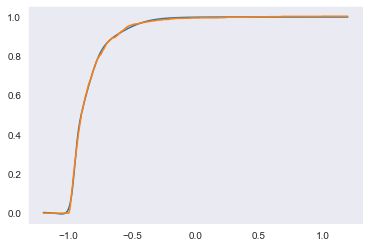

Train on 5462 samples
Epoch 1/150
5462/5462 - 1s - loss: 0.2431
Epoch 2/150
5462/5462 - 1s - loss: 0.1799
Epoch 3/150
5462/5462 - 1s - loss: 0.1308
Epoch 4/150
5462/5462 - 1s - loss: 0.0673
Epoch 5/150
5462/5462 - 1s - loss: 0.0259
Epoch 6/150
5462/5462 - 1s - loss: 0.0079
Epoch 7/150
5462/5462 - 1s - loss: 0.0023
Epoch 8/150
5462/5462 - 1s - loss: 0.0011
Epoch 9/150
5462/5462 - 1s - loss: 9.2346e-04
Epoch 10/150
5462/5462 - 1s - loss: 8.8873e-04
Epoch 11/150
5462/5462 - 1s - loss: 8.5956e-04
Epoch 12/150
5462/5462 - 1s - loss: 8.3267e-04
Epoch 13/150
5462/5462 - 1s - loss: 8.0692e-04
Epoch 14/150
5462/5462 - 1s - loss: 7.8282e-04
Epoch 15/150
5462/5462 - 1s - loss: 7.5025e-04
Epoch 16/150
5462/5462 - 1s - loss: 7.3256e-04
Epoch 17/150
5462/5462 - 1s - loss: 7.1249e-04
Epoch 18/150
5462/5462 - 1s - loss: 6.9599e-04
Epoch 19/150
5462/5462 - 1s - loss: 6.7449e-04
Epoch 20/150
5462/5462 - 1s - loss: 6.6017e-04
Epoch 21/150
5462/5462 - 1s - loss: 6.4822e-04
Epoch 22/150
5462/5462 - 1s - lo

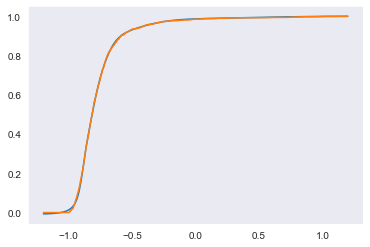

Train on 5462 samples
Epoch 1/150
5462/5462 - 1s - loss: 0.2223
Epoch 2/150
5462/5462 - 1s - loss: 0.1485
Epoch 3/150
5462/5462 - 1s - loss: 0.0927
Epoch 4/150
5462/5462 - 1s - loss: 0.0272
Epoch 5/150
5462/5462 - 1s - loss: 0.0101
Epoch 6/150
5462/5462 - 1s - loss: 0.0052
Epoch 7/150
5462/5462 - 1s - loss: 0.0016
Epoch 8/150
5462/5462 - 1s - loss: 7.8995e-04
Epoch 9/150
5462/5462 - 1s - loss: 6.8950e-04
Epoch 10/150
5462/5462 - 1s - loss: 6.6961e-04
Epoch 11/150
5462/5462 - 1s - loss: 6.6655e-04
Epoch 12/150
5462/5462 - 1s - loss: 6.6290e-04
Epoch 13/150
5462/5462 - 1s - loss: 6.6209e-04
Epoch 14/150
5462/5462 - 1s - loss: 6.5317e-04
Epoch 15/150
5462/5462 - 1s - loss: 6.5882e-04
Epoch 16/150
5462/5462 - 1s - loss: 6.4698e-04
Epoch 17/150
5462/5462 - 1s - loss: 6.4325e-04
Epoch 18/150
5462/5462 - 1s - loss: 6.4127e-04
Epoch 19/150
5462/5462 - 1s - loss: 6.3968e-04
Epoch 20/150
5462/5462 - 1s - loss: 6.3272e-04
Epoch 21/150
5462/5462 - 1s - loss: 6.3524e-04
Epoch 22/150
5462/5462 - 1s 

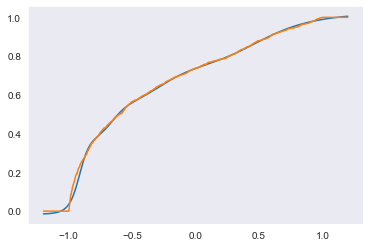

Train on 5462 samples
Epoch 1/150
5462/5462 - 2s - loss: 0.2430
Epoch 2/150
5462/5462 - 1s - loss: 0.1875
Epoch 3/150
5462/5462 - 1s - loss: 0.0865
Epoch 4/150
5462/5462 - 1s - loss: 0.0144
Epoch 5/150
5462/5462 - 1s - loss: 0.0010
Epoch 6/150
5462/5462 - 1s - loss: 2.1037e-04
Epoch 7/150
5462/5462 - 1s - loss: 1.0499e-04
Epoch 8/150
5462/5462 - 1s - loss: 3.4536e-05
Epoch 9/150
5462/5462 - 1s - loss: 1.9372e-05
Epoch 10/150
5462/5462 - 1s - loss: 1.7377e-05
Epoch 11/150
5462/5462 - 1s - loss: 1.5903e-05
Epoch 12/150
5462/5462 - 1s - loss: 1.4160e-05
Epoch 13/150
5462/5462 - 1s - loss: 1.2727e-05
Epoch 14/150
5462/5462 - 1s - loss: 1.1442e-05
Epoch 15/150
5462/5462 - 1s - loss: 1.0205e-05
Epoch 16/150
5462/5462 - 1s - loss: 9.5963e-06
Epoch 17/150
5462/5462 - 1s - loss: 9.0437e-06
Epoch 18/150
5462/5462 - 1s - loss: 1.0624e-05
Epoch 19/150
5462/5462 - 1s - loss: 9.4655e-06
Epoch 20/150
5462/5462 - 1s - loss: 9.1208e-06
12  Finished fitting   Decay X (cm)


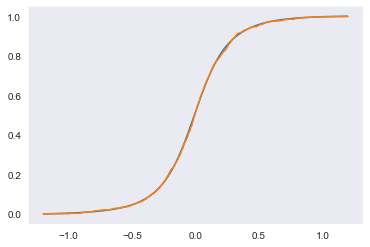

Train on 5462 samples
Epoch 1/150
5462/5462 - 1s - loss: 0.2488
Epoch 2/150
5462/5462 - 1s - loss: 0.2088
Epoch 3/150
5462/5462 - 1s - loss: 0.1486
Epoch 4/150
5462/5462 - 1s - loss: 0.0413
Epoch 5/150
5462/5462 - 1s - loss: 0.0035
Epoch 6/150
5462/5462 - 1s - loss: 6.3973e-04
Epoch 7/150
5462/5462 - 1s - loss: 4.6220e-04
Epoch 8/150
5462/5462 - 1s - loss: 3.4789e-04
Epoch 9/150
5462/5462 - 1s - loss: 2.5618e-04
Epoch 10/150
5462/5462 - 1s - loss: 1.8651e-04
Epoch 11/150
5462/5462 - 1s - loss: 1.3833e-04
Epoch 12/150
5462/5462 - 1s - loss: 1.0806e-04
Epoch 13/150
5462/5462 - 1s - loss: 9.1622e-05
Epoch 14/150
5462/5462 - 1s - loss: 8.4328e-05
Epoch 15/150
5462/5462 - 1s - loss: 8.1249e-05
Epoch 16/150
5462/5462 - 1s - loss: 7.8412e-05
Epoch 17/150
5462/5462 - 1s - loss: 7.4365e-05
Epoch 18/150
5462/5462 - 1s - loss: 7.1323e-05
Epoch 19/150
5462/5462 - 1s - loss: 5.9268e-05
Epoch 20/150
5462/5462 - 1s - loss: 4.0837e-05
Epoch 21/150
5462/5462 - 1s - loss: 2.4964e-05
Epoch 22/150
5462/54

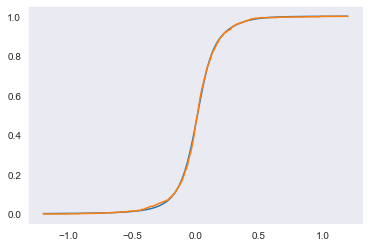

In [265]:
fitParams1 = {'verbose':2, 
             'xrange_excess': 0.2,
             'density': 0.3,
             'edge_density_mult':3}

mf_background = MultiFeature(FullBackground_file, feature_names, parameters={'trainParams': trainParams, 'compileArgs':compileArgs}, xrange = (-1,1))
mf_background.normalise_range(4, (-1,10))


# mf_background.get_distribuitions_from_file(filename)
mf_background.fitAll(fitParams1)

Attempting refits on the worse fits

1  Mother Transverse Momentum (GeV/c)
Train on 3310 samples
Epoch 1/450
3310/3310 - 1s - loss: 9.2935e-04
Epoch 2/450
3310/3310 - 0s - loss: 8.8977e-04
Epoch 3/450
3310/3310 - 0s - loss: 8.5622e-04
Epoch 4/450
3310/3310 - 0s - loss: 8.3300e-04
Epoch 5/450
3310/3310 - 0s - loss: 8.1025e-04
Epoch 6/450
3310/3310 - 0s - loss: 7.9180e-04
Epoch 7/450
3310/3310 - 0s - loss: 7.7763e-04
Epoch 8/450
3310/3310 - 0s - loss: 7.5400e-04
Epoch 9/450
3310/3310 - 1s - loss: 7.2972e-04
Epoch 10/450
3310/3310 - 1s - loss: 6.9939e-04
Epoch 11/450
3310/3310 - 0s - loss: 7.0317e-04
Epoch 12/450
3310/3310 - 0s - loss: 6.9388e-04
Epoch 13/450
3310/3310 - 1s - loss: 6.8290e-04
Epoch 14/450
3310/3310 - 0s - loss: 6.4694e-04
Epoch 15/450
3310/3310 - 0s - loss: 6.4236e-04
Epoch 16/450
3310/3310 - 0s - loss: 6.3109e-04
Epoch 17/450
3310/3310 - 0s - loss: 6.2144e-04
Epoch 18/450
3310/3310 - 0s - loss: 5.9455e-04
Epoch 19/450
3310/3310 - 0s - loss: 6.1367e-04
Epoch 20/450
3310/3310 - 0s - loss: 5.8900e-04
Epoch 21/

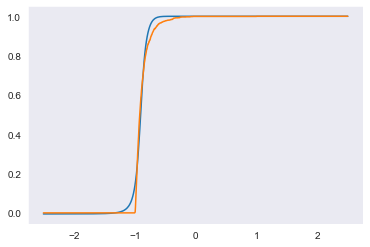

3  Opening Angle (rad)
Train on 3310 samples
Epoch 1/450
3310/3310 - 1s - loss: 5.4411e-04
Epoch 2/450
3310/3310 - 0s - loss: 5.2335e-04
Epoch 3/450
3310/3310 - 0s - loss: 5.1464e-04
Epoch 4/450
3310/3310 - 0s - loss: 4.9971e-04
Epoch 5/450
3310/3310 - 0s - loss: 4.9247e-04
Epoch 6/450
3310/3310 - 0s - loss: 4.7768e-04
Epoch 7/450
3310/3310 - 0s - loss: 4.6556e-04
Epoch 8/450
3310/3310 - 0s - loss: 4.6339e-04
Epoch 9/450
3310/3310 - 0s - loss: 4.5809e-04
Epoch 10/450
3310/3310 - 1s - loss: 4.3978e-04
Epoch 11/450
3310/3310 - 1s - loss: 4.3123e-04
Epoch 12/450
3310/3310 - 0s - loss: 4.1673e-04
Epoch 13/450
3310/3310 - 0s - loss: 4.0020e-04
Epoch 14/450
3310/3310 - 0s - loss: 3.8291e-04
Epoch 15/450
3310/3310 - 0s - loss: 3.5598e-04
Epoch 16/450
3310/3310 - 0s - loss: 3.3153e-04
Epoch 17/450
3310/3310 - 0s - loss: 3.0912e-04
Epoch 18/450
3310/3310 - 0s - loss: 2.8852e-04
Epoch 19/450
3310/3310 - 0s - loss: 2.6694e-04
Epoch 20/450
3310/3310 - 0s - loss: 2.4720e-04
Epoch 21/450
3310/3310 -

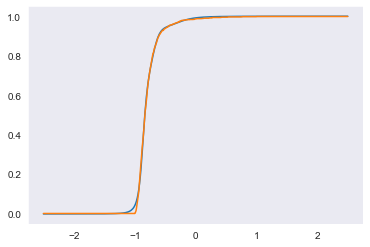

9  Daughter2 Transverse Momentum (GeV/c)
Train on 3310 samples
Epoch 1/450
3310/3310 - 1s - loss: 5.6967e-04
Epoch 2/450
3310/3310 - 1s - loss: 5.5228e-04
Epoch 3/450
3310/3310 - 0s - loss: 5.3868e-04
Epoch 4/450
3310/3310 - 0s - loss: 5.1291e-04
Epoch 5/450
3310/3310 - 0s - loss: 5.0232e-04
Epoch 6/450
3310/3310 - 0s - loss: 4.8446e-04
Epoch 7/450
3310/3310 - 0s - loss: 4.7718e-04
Epoch 8/450
3310/3310 - 0s - loss: 4.6583e-04
Epoch 9/450
3310/3310 - 0s - loss: 4.5916e-04
Epoch 10/450
3310/3310 - 0s - loss: 4.4245e-04
Epoch 11/450
3310/3310 - 0s - loss: 4.2147e-04
Epoch 12/450
3310/3310 - 0s - loss: 4.2863e-04
Epoch 13/450
3310/3310 - 0s - loss: 4.0387e-04
Epoch 14/450
3310/3310 - 0s - loss: 4.0412e-04
Epoch 15/450
3310/3310 - 1s - loss: 3.8289e-04
Epoch 16/450
3310/3310 - 1s - loss: 3.8066e-04
Epoch 17/450
3310/3310 - 0s - loss: 3.6522e-04
Epoch 18/450
3310/3310 - 1s - loss: 3.6867e-04
Epoch 19/450
3310/3310 - 1s - loss: 3.5351e-04
Epoch 20/450
3310/3310 - 1s - loss: 3.4541e-04
Epoch 

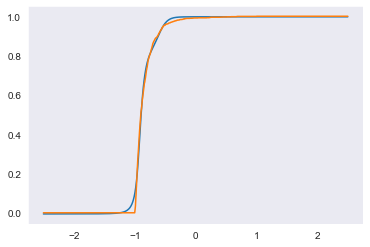

In [289]:
refit_params = {'verbose':2, 
                'xrange_excess': 1.5,
                'density': 0.1,
                'edge_density_mult':1}

refit_train = {'epochs' : 450,
            'batch_size' : 10, 
                'verbose' : 2}

refit_array = [1, 3, 9]

# 2, 4, 5, 10
for k in refit_array:
    print(k, feature_names[k])
#     mf_background.resetFit(k)
    mf_background.fitFeature(k, refit_params, refit_train)
    plt.show()
    # mf_signal.drawDistComparison(k)
    # plt.show()


1  Mother Transverse Momentum (GeV/c)


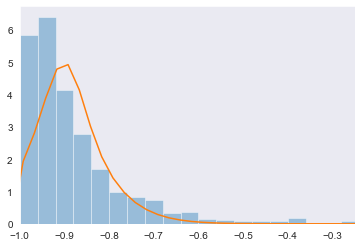

3  Opening Angle (rad)


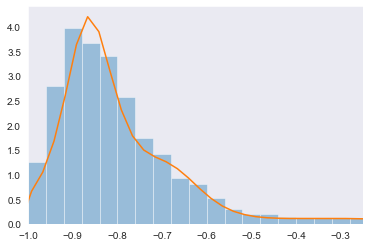

9  Daughter2 Transverse Momentum (GeV/c)


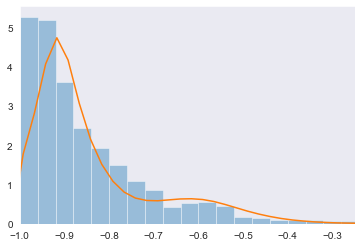

In [290]:
for k in refit_array:
    print(k, feature_names[k])
    # mf_signal.distfit_array[feat].plotIntegratedComparison()
    mf_background.drawDistComparison(k)
    plt.xlim((-1,-0.25))
    plt.show()

(-1.0, -0.25)

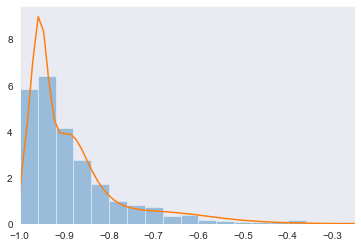

In [273]:
mf_background.drawDistComparison(1)
plt.xlim((-1,-0.25))

Showing fit results

0 Mother Total Momentum (GeV/c)


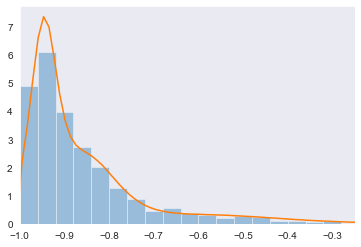

1  Mother Transverse Momentum (GeV/c)


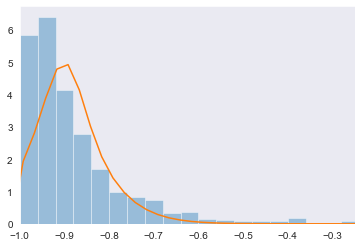

2  Mother Fraction of Transverse Momentum


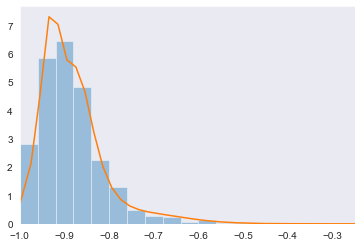

3  Opening Angle (rad)


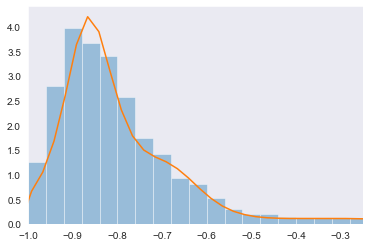

4  Impact Parameter (cm)


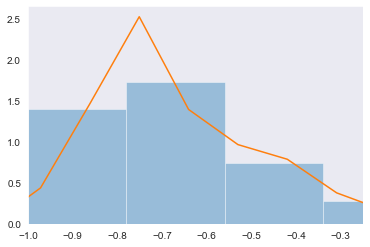

5  Daughter1 Total Momentum (GeV/c)


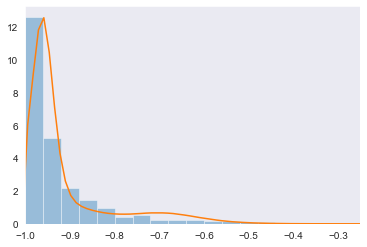

6  Daughter1 Transverse Momentum (GeV/c)


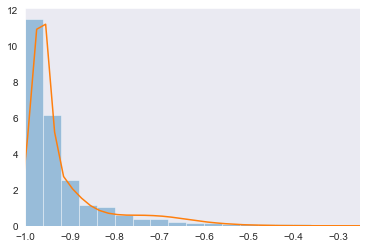

7  Daughter1 Fraction of Transverse Momentum


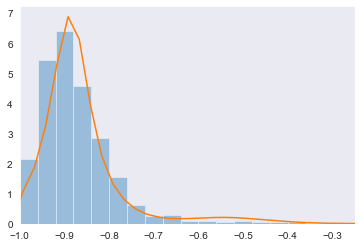

8  Daughter2 Total Momentum (GeV/c)


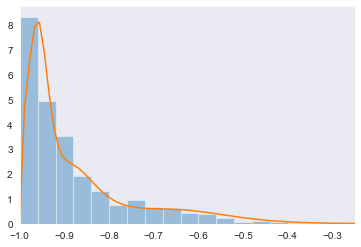

9  Daughter2 Transverse Momentum (GeV/c)


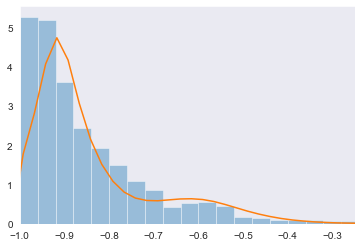

10  Daughter2 Fraction of Transverse Momentum


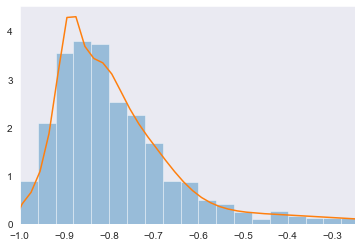

11  Decay Z (cm)


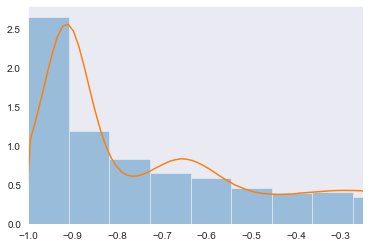

12  Decay X (cm)


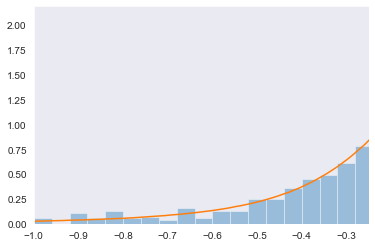

13  Decay Y (cm)


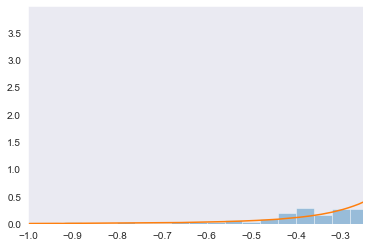

In [291]:
for k, feat in enumerate(feature_names):
    print(k, feat)
    # mf_signal.distfit_array[feat].plotIntegratedComparison()
    mf_background.drawDistComparison(k)
    plt.xlim((-1,-0.25))
    plt.show()

In [292]:
# filename = "/content/drive/My Drive/Neutralinos/Network Saves/background-{}".format(decay_select['decay'])
dirname = "Network Saves/"
filename = "{}/background-4-{}/".format(dirname, decay_select['decay'])

mf_background.save_distribuitions_to_file(filename)